# Experiments

Just to be clear, the following examples are for demonstration and testing purposes only. Users are not supposed to make their own dummy batches using their own data. Refer to the pages **High-Level API** and/ or **Low-Level API** if you actually want to use the library. 

## Prerequisites
* If you've already completed the instructions on the **Installation** page, then let's get started.
* This section makes use of the data in the **Example Datasets** page.

In [1]:
import os 
os.chdir('/Users/Layne/Desktop/aiqc')

In [2]:
import aiqc
from aiqc import examples

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
#aiqc.delete_db(True)


=> Success - deleted database file at path:
/Users/layne/Library/Application Support/aiqc/aiqc.sqlite3



In [4]:
# from importlib import reload
# reload(aiqc)

<module 'aiqc' from '/Users/layne/Desktop/aiqc/aiqc/__init__.py'>

In [5]:
# aiqc.create_db()


=> Success - created database file for machine learning metrics at path:
/Users/layne/Library/Application Support/aiqc/aiqc.sqlite3


=> Success - created the following tables within database:
['algorithm', 'batch', 'datapipeline', 'dataset', 'experiment', 'featureset', 'file', 'fold', 'foldset', 'hyperparamcombo', 'hyperparamset', 'image', 'job', 'label', 'preprocess', 'result', 'splitset', 'tabular']



## Dummy Experiments

The `list_demo_batches()` method describes the predefined experiments that are available.

> By default it returns a Pandas DataFrame, but you can `list_demo_files(format='list')` to change that.

In [20]:
examples.list_demo_batches()

,batch_name,data_type,supervision,analysis,sub_analysis,validation,fileset
0,multiclass,tabular,supervised,classification,multi label,validation split,iris.tsv
1,binary,tabular,supervised,classification,binary,validation split,sonar.csv
2,continuous,tabular,supervised,regression,None,validation split,houses.csv
3,multiclass_folded,tabular,supervised,classification,multi label,cross-folds,iris_10x.tsv
4,continuous_folded,tabular,supervised,regression,None,cross-folds,houses.csv


* Each `Batch` contains predefined training `Jobs` and a `Hyperparamset`.
  * Each `Job` is comprised of:
    * An `Algorithm` and a unique `Hyperparamcombo`.
    * They gets fit to a `Datasets` made from a dummy data file seen above.
      * More specifically, its `Labels, Featuresets` are sliced into `Splitsets, Foldsets`.

## Example: supervised regression

The entries from the `name` column above, can be fed into the `make_demo_batch()` method.

In [21]:
batch = examples.make_demo_batch('regression')

ValueError: 
Yikes - The 'name' you specified <regression> was not found.
Tip - Check the names in 'examples.list_demo_batches()'.


In [8]:
batch.splitset.label.unique_classes

### ORM in action

It's easy to dig into the Batches using the ORM to see how they are constructed.

In [9]:
batch.job_count

4

In [10]:
batch.jobs[3].hyperparamcombo.hyperparameters

{'neuron_count': 48, 'epochs': 75}

In [11]:
batch.splitset.featureset.dataset.files[0].file_format

'parquet'

In [12]:
batch.algorithm.function_model_train

<function aiqc.examples.regression_model_train(model, samples_train, samples_evaluate, **hyperparameters)>

### Hyperparameter tuning in action

When you execute a Batch of Jobs, it will run the jobs on a background process, so you can continue to work in your Python shell.

> It does this by spawning a `multiprocessing.Process` that lives until each Job is completed or the process is killed.

In [13]:
batch.run_jobs()

🔮 Training Models 🔮:  25%|██████████▌                               | 1/4 [00:05<00:16,  5.64s/it]

The execution of the Jobs can easily be stopped, and then resumed at the Job that was previously running.

In [14]:
batch.stop_jobs()


Killed `multiprocessing.Process` 'aiqc_batch_1' spawned from Batch <id:1>



In [15]:
batch.run_jobs()


Resuming jobs...



🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 4/4 [00:21<00:00,  5.43s/it]


### Inspecting the Result of an Individual Job

When each Job completes, it will create a `Result` that contains `predictions` and `metrics` attributes for each split/ fold.

In [17]:
batch.jobs[1].results[0].metrics

{'test': {'r2': 0.7028589262695772,
  'mse': 0.2550449723629628,
  'explained_variance': 0.7033104032731781,
  'loss': 0.25504496693611145},
 'validation': {'r2': 0.7586127539355636,
  'mse': 0.2545659263091343,
  'explained_variance': 0.7594164485666008,
  'loss': 0.25456592440605164},
 'train': {'r2': 0.755649536524687,
  'mse': 0.24435046347531306,
  'explained_variance': 0.7557585527324248,
  'loss': 0.24435044825077057}}

The JSON values of these attributes are interoperable with Python dictionaries.

In [20]:
batch.jobs[3].results[0].predictions['validation']

array([[-0.60206497],
       [ 0.8861952 ],
       [ 0.6425036 ],
       [ 0.00414339],
       [ 0.5579922 ],
       [-0.4399129 ],
       [-0.00622949],
       [-0.68307793],
       [ 2.8606904 ],
       [-0.13770762],
       [-0.30969015],
       [ 0.05348143],
       [-0.21649757],
       [ 0.80401444],
       [ 0.9941528 ],
       [ 1.2406036 ],
       [-0.04374141],
       [ 0.1065982 ],
       [ 0.41903755],
       [-0.76732457],
       [-0.3254651 ],
       [ 0.8148873 ],
       [-0.0247415 ],
       [-1.0226299 ],
       [-0.96497047],
       [-0.41967395],
       [-0.28828695],
       [-0.47470275],
       [ 0.63171804],
       [ 1.9143739 ],
       [-0.64005864],
       [-0.14083937],
       [-0.01868173],
       [-0.1530954 ],
       [ 1.0661846 ],
       [-0.44390264],
       [ 1.6199763 ],
       [-0.19630864],
       [-0.99270356],
       [-0.5327172 ],
       [ 0.5426311 ],
       [ 0.21416108],
       [-0.34406623],
       [ 1.5983316 ],
       [ 0.49417928],
       [-0

### Inspecting the metrics of the entire Batch

In [21]:
batch.metrics_to_pandas()

,job_id,split,r2,mse,explained_variance,loss
0,1,test,0.712765,0.246542,0.714026,0.246542
1,1,validation,0.776292,0.235921,0.776550,0.235921
2,1,train,0.788742,0.211258,0.788925,0.211258
3,2,test,0.702859,0.255045,0.703310,0.255045
4,2,validation,0.758613,0.254566,0.759416,0.254566
5,2,train,0.755650,0.244350,0.755759,0.244350
6,3,test,0.727863,0.233584,0.763783,0.233584
7,3,validation,0.770581,0.241944,0.811797,0.241944
8,3,train,0.754616,0.245384,0.795402,0.245384
9,4,test,0.713577,0.245845,0.724897,0.245845


## Example: supervised multi-classification with cross-fold validation

The following method uses *demo_file* 'iris_10x.tsv', so if you see duplicate samples that is why.

In [4]:
batch = examples.make_demo_batch('multiclass_folded')

In [23]:
batch.splitset.label.unique_classes

[0, 1, 2]

In [5]:
batch.run_jobs()

🔮 Training Models 🔮: 100%|████████████████████████████████████████| 10/10 [00:48<00:00,  4.88s/it]


In [6]:
batch.job_count

10

In [27]:
batch.metrics_to_pandas()

,job_id,split,roc_auc,accuracy,precision,recall,f1,loss
0,5,test,0.999763,0.986667,0.986724,0.986667,0.986666,0.036607
1,5,folds_train_combined,0.999641,0.984524,0.984530,0.984524,0.984525,0.040695
2,5,fold_validation,1.000000,0.995238,0.995320,0.995238,0.995243,0.027615
3,6,test,1.000000,0.991111,0.991342,0.991111,0.991110,0.019178
4,6,folds_train_combined,1.000000,0.992857,0.993000,0.992857,0.992854,0.019741
5,6,fold_validation,1.000000,0.995238,0.995320,0.995238,0.995243,0.012979
6,7,test,0.999881,0.991111,0.991342,0.991111,0.991110,0.038708
7,7,folds_train_combined,0.999872,0.994048,0.994150,0.994048,0.994046,0.037343
8,7,fold_validation,0.999866,0.990476,0.990769,0.990476,0.990484,0.042127
9,8,test,1.000000,0.982222,0.983122,0.982222,0.982210,0.032874


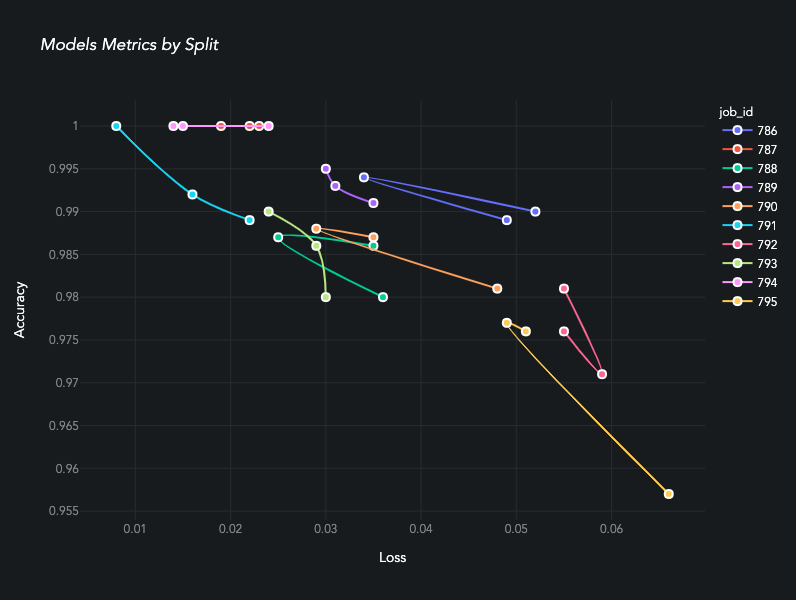

In [9]:
batch.plot_performance(max_loss=0.9, min_acc=0.5)

### API Details

For more detailed information reference the **Low-Level API** documentation.

### Metrics & Visualization

For more information of visualization of performance metrics, reference the **Visualization & Metrics** documentation.

In [7]:
batch = examples.make_demo_batch('regression')

In [8]:
batch.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 4/4 [00:28<00:00,  7.11s/it]


In [10]:
batch = examples.make_demo_batch('regression_folded')

In [11]:
batch.run_jobs()

🔮 Training Models 🔮:  31%|████████████▊                            | 5/16 [00:30<01:05,  5.97s/it]

In [13]:
batch.plot_performance(max_loss=10000, min_acc=0)

ValueError: 
Yikes - Cannot use argument `min_acc` if `batch.analysis_type='regression'`.
